# kospi
- Realized Volatility Forecasting with GARCH 


In [1]:
# !pip install arch

In [2]:
# !pip3 install yfinance

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR MODEL PERFORMANCE DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

In [7]:
# PRE-SET PATH TO images FOLDER TO SAVE PLOTS LATER
directory_to_img = os.path.join('images')

In [8]:
df = pd.read_csv("kospi.csv")

In [9]:
tckr = 'kospi'

In [10]:
df.shape

(4657, 7)

In [11]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2003-01-02,637.099976,623.750000,633.030029,635.169983,742900.0,635.169983
1,2003-01-03,662.400024,649.619995,651.590027,661.099976,1005800.0,661.099976
2,2003-01-06,667.710022,657.609985,665.099976,666.710022,721800.0,666.710022
3,2003-01-07,679.299988,652.140015,679.000000,652.200012,690100.0,652.200012
4,2003-01-08,660.390015,650.929993,655.969971,651.719971,604900.0,651.719971


In [12]:
df['Change']    = 100*df['Close'].pct_change()
df['STDEV']     = df['Close'].rolling(window=20).std(ddof=0)
df['STDEV_log'] = np.log(df['Close'].rolling(window=20).std(ddof=0))
df['HV']        = df['Change'].rolling(window=20, center=False).std() * (252 ** 0.5)
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [13]:
# df['Change']    = df['Close'].pct_change()
# df['STDEV']     = df['Close'].rolling(window=20).std(ddof=0)
# df['STDEV_log'] = np.log(df['Close'].rolling(window=20).std(ddof=0))
# df['HV']        = df['Change'].rolling(window=20, center=False).std() * (252 ** 0.5)


In [14]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Change,STDEV,STDEV_log,HV,log_returns
0,2003-01-02,637.099976,623.750000,633.030029,635.169983,742900.0,635.169983,NaN,NaN,NaN,NaN,NaN
1,2003-01-03,662.400024,649.619995,651.590027,661.099976,1005800.0,661.099976,4.082371,NaN,NaN,NaN,0.040012
2,2003-01-06,667.710022,657.609985,665.099976,666.710022,721800.0,666.710022,0.848593,NaN,NaN,NaN,0.008450
3,2003-01-07,679.299988,652.140015,679.000000,652.200012,690100.0,652.200012,-2.176360,NaN,NaN,NaN,-0.022004
4,2003-01-08,660.390015,650.929993,655.969971,651.719971,604900.0,651.719971,-0.073603,NaN,NaN,NaN,-0.000736


In [15]:
INTERVAL_WINDOW = 20
n_future = 5

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['STDEV_current'] = df['STDEV']
# df['stdev_current'] = df['stdev']                                   

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['STDEV_future'] = df['STDEV'].shift(-n_future)
# df['stdev_future'] = df['stdev'].shift(-n_future)

In [16]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close,Change,STDEV,STDEV_log,HV,log_returns,STDEV_current,STDEV_future
count,4657.000000,4657.000000,4657.000000,4657.000000,4.657000e+03,4657.000000,4656.000000,4638.000000,4638.000000,4637.000000,4656.000000,4638.000000,4638.000000
mean,1805.001501,1782.988552,1795.407493,1794.560373,4.562680e+05,1794.560373,0.041300,32.287789,3.320846,17.622491,0.000331,32.287789,32.287789
std,568.341191,564.751954,566.786450,566.354505,2.498565e+05,566.354505,1.277017,21.400541,0.530666,10.032516,0.012799,21.400541,21.400541
min,531.780029,512.299988,529.070007,515.239990,1.363000e+05,515.239990,-10.570535,5.559850,1.715571,4.579286,-0.111720,5.559850,5.559850
25%,1423.069946,1405.050049,1414.550049,1414.880005,3.110000e+05,1414.880005,-0.515598,19.314554,2.960859,11.265834,-0.005169,19.314554,19.314554
50%,1938.040039,1916.810059,1930.089966,1927.819946,3.913000e+05,1927.819946,0.072411,26.165200,3.264430,14.947348,0.000724,26.165200,26.165200
75%,2081.159912,2061.129883,2071.409912,2070.540039,5.100000e+05,2070.540039,0.679595,38.091505,3.639991,20.828688,0.006773,38.091505,38.091505
max,3316.080078,3295.439941,3305.459961,3305.209961,3.455500e+06,3305.209961,11.945675,209.305279,5.343794,91.140888,0.112844,209.305279,209.305279


In [17]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Change,STDEV,STDEV_log,HV,log_returns,STDEV_current,STDEV_future
0,2003-01-02,637.099976,623.750000,633.030029,635.169983,742900.0,635.169983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-01-03,662.400024,649.619995,651.590027,661.099976,1005800.0,661.099976,4.082371,NaN,NaN,NaN,0.040012,NaN,NaN
2,2003-01-06,667.710022,657.609985,665.099976,666.710022,721800.0,666.710022,0.848593,NaN,NaN,NaN,0.008450,NaN,NaN
3,2003-01-07,679.299988,652.140015,679.000000,652.200012,690100.0,652.200012,-2.176360,NaN,NaN,NaN,-0.022004,NaN,NaN
4,2003-01-08,660.390015,650.929993,655.969971,651.719971,604900.0,651.719971,-0.073603,NaN,NaN,NaN,-0.000736,NaN,NaN


## **Train-Validation-Test Splits**

In [18]:
df = df.set_index('Date')
df.head()

,High,Low,Open,Close,Volume,Adj Close,Change,STDEV,STDEV_log,HV,log_returns,STDEV_current,STDEV_future
Date,,,,,,,,,,,,,
2003-01-02,637.099976,623.750000,633.030029,635.169983,742900.0,635.169983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-03,662.400024,649.619995,651.590027,661.099976,1005800.0,661.099976,4.082371,NaN,NaN,NaN,0.040012,NaN,NaN
2003-01-06,667.710022,657.609985,665.099976,666.710022,721800.0,666.710022,0.848593,NaN,NaN,NaN,0.008450,NaN,NaN
2003-01-07,679.299988,652.140015,679.000000,652.200012,690100.0,652.200012,-2.176360,NaN,NaN,NaN,-0.022004,NaN,NaN
2003-01-08,660.390015,650.929993,655.969971,651.719971,604900.0,651.719971,-0.073603,NaN,NaN,NaN,-0.000736,NaN,NaN


In [19]:
df= df.loc['2003-09-29':'2021-09-28'] 

In [20]:
train_df = df.loc['2003-09-29':'2020-09-28']    # 2003-9-29 ~ 2020-9-28
val_df = df.loc['2020-09-29':'2021-09-28']  # 2020-9-29 ~ 2021-9-28


In [21]:
val_df.tail()

,High,Low,Open,Close,Volume,Adj Close,Change,STDEV,STDEV_log,HV,log_returns,STDEV_current,STDEV_future
Date,,,,,,,,,,,,,
2021-09-17,3142.129883,3112.510010,3127.750000,3140.510010,587500.0,3140.510010,0.332895,32.004813,3.465886,12.974706,0.003323,32.004813,37.627612
2021-09-23,3131.629883,3107.979980,3123.639893,3127.580078,623000.0,3127.580078,-0.411714,29.257311,3.376130,12.715485,-0.004126,29.257311,41.436633
2021-09-24,3146.860107,3119.399902,3140.729980,3125.239990,752800.0,3125.239990,-0.074821,29.761260,3.393208,11.428295,-0.000748,29.761260,47.671655
2021-09-27,3146.350098,3119.260010,3121.699951,3133.639893,882600.0,3133.639893,0.268776,30.062048,3.403264,11.427495,0.002684,30.062048,58.059605
2021-09-28,3134.459961,3095.719971,3133.399902,3097.919922,894100.0,3097.919922,-1.139888,32.013210,3.466149,11.952561,-0.011464,32.013210,73.251357


In [22]:
# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = train_df.index
val_idx = val_df.index

In [23]:
val_idx

Index(['2020-09-29', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
       '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16',
       ...
       '2021-09-10', '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16',
       '2021-09-17', '2021-09-23', '2021-09-24', '2021-09-27', '2021-09-28'],
      dtype='object', name='Date', length=245)

In [24]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'val \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')

TRAINING 	From: 2003-09-29 	to: 2020-09-28 	4199 days
val 	From: 2020-09-29 	to: 2021-09-28 	245 days


In [25]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.STDEV_future[train_idx]
y_val = df.STDEV_future[val_idx]

In [26]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.STDEV_current[train_idx]
x_val = df.STDEV_current[val_idx]

In [27]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.Change[train_idx]
r_val = df.Change[val_idx]

In [28]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]

In [29]:
y_train.describe()

count    4199.000000
mean       31.663741
std        20.580288
min         5.559850
25%        19.312678
50%        25.920366
75%        37.090177
max       209.305279
Name: STDEV_future, dtype: float64

In [30]:
x_train.describe()

count    4199.000000
mean       31.638003
std        20.573510
min         5.559850
25%        19.312678
50%        25.917172
75%        37.002922
max       209.305279
Name: STDEV_current, dtype: float64

## **Data Preprocessing**

### 1. Feature Normalization

 `MinMaxScaler`

In [31]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [32]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [33]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

In [34]:
x_train_scaled

Date
2003-09-29    0.091117
2003-09-30    0.101550
2003-10-01    0.106555
2003-10-02    0.106332
2003-10-06    0.103187
                ...   
2020-09-22    0.131163
2020-09-23    0.139595
2020-09-24    0.173262
2020-09-25    0.198754
2020-09-28    0.204185
Length: 4199, dtype: float64

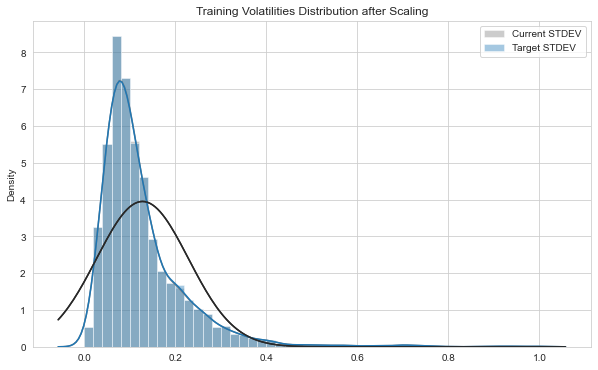

In [35]:
# PLOTTING VOLATILITIES AFTER SCALING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current STDEV')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target STDEV')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.savefig(os.path.join(directory_to_img, "vol_dist.png"), 
                dpi=300, bbox_inches='tight')
    plt.show();

# Modeling


In [36]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [37]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [38]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation STDEV RMSPE', 'Validation STDEV RMSE'])

In [39]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred),
                                       ]
    return perf_df

In [40]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
# shift 이용해서 그래프 겹치게 만들 것
# x축 눈금 간격 조정하는 URL
# https://zephyrus1111.tistory.com/127
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily STDEV")
        
        plt.plot(y_true.shift(4), color='blue', lw=2, 
                label=f"Target STDEV")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted STDEV')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

## 2. Baseline Models

### 2.1. Mean Baseline

the average current realized volatility of the whole training set as predictions everything.

In [41]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_val_vol = x_val_scaled.mean()
mean_val_vol

0.22015609004188474

In [42]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_val_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

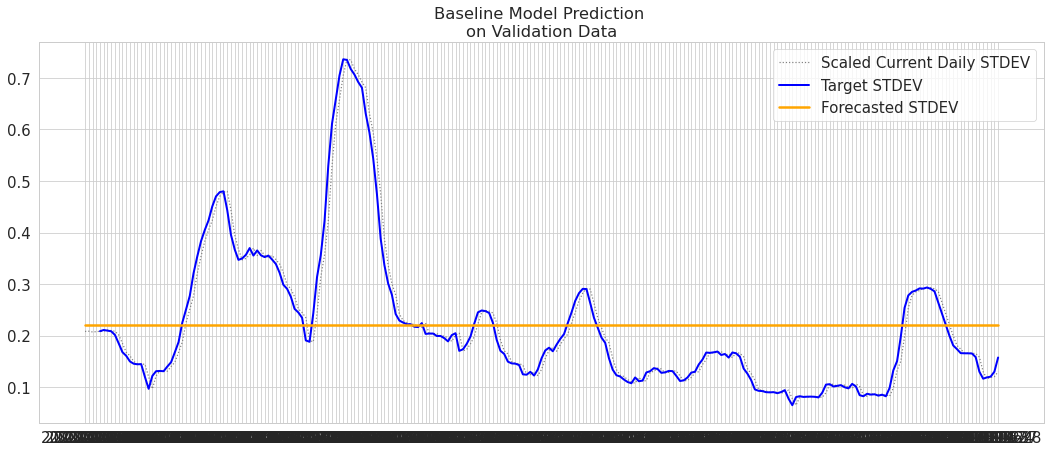

In [43]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Prediction")
plt.savefig(os.path.join(directory_to_img, 'baseline.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [44]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

,Model,Validation STDEV RMSPE,Validation STDEV RMSE
0,Mean Baseline,0.731533,0.138895


### 2.2. Random Walk Naive Forecasting

In [45]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

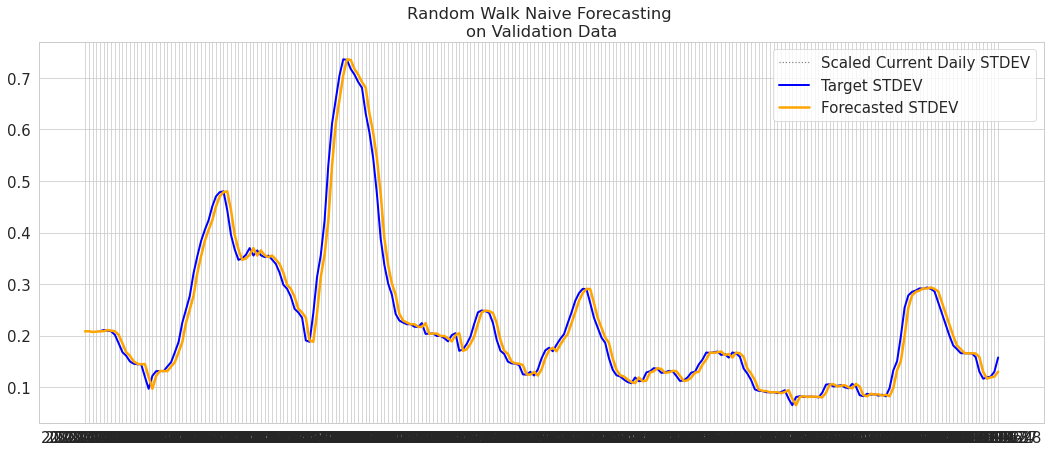

In [46]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.savefig(os.path.join(directory_to_img, 'naive.jpg'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [47]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

,Model,Validation STDEV RMSPE,Validation STDEV RMSE
0,Mean Baseline,0.731533,0.138895
1,Random Walk Naive Forecasting,0.326999,0.091715


### 3.1. Basic GARCH
(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html#Specifying-Common-Models)

In [48]:
from arch import arch_model

In [49]:
seed = 1234

### GARCH(1,1)

In [50]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6134.01
Distribution:                  Normal   AIC:                           12276.0
Method:            Maximum Likelihood   BIC:                           12301.4
                                        No. Observations:                 4199
Date:                Wed, Nov 17 2021   Df Residuals:                     4198
Time:                        11:16:47   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0521  1.435e-02      3.634  2.795e-04 [2

In [51]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [52]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [53]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily STDEV')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated STDEV')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

In [ ]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

#### 3.1.1. Analytical-based Forecasting


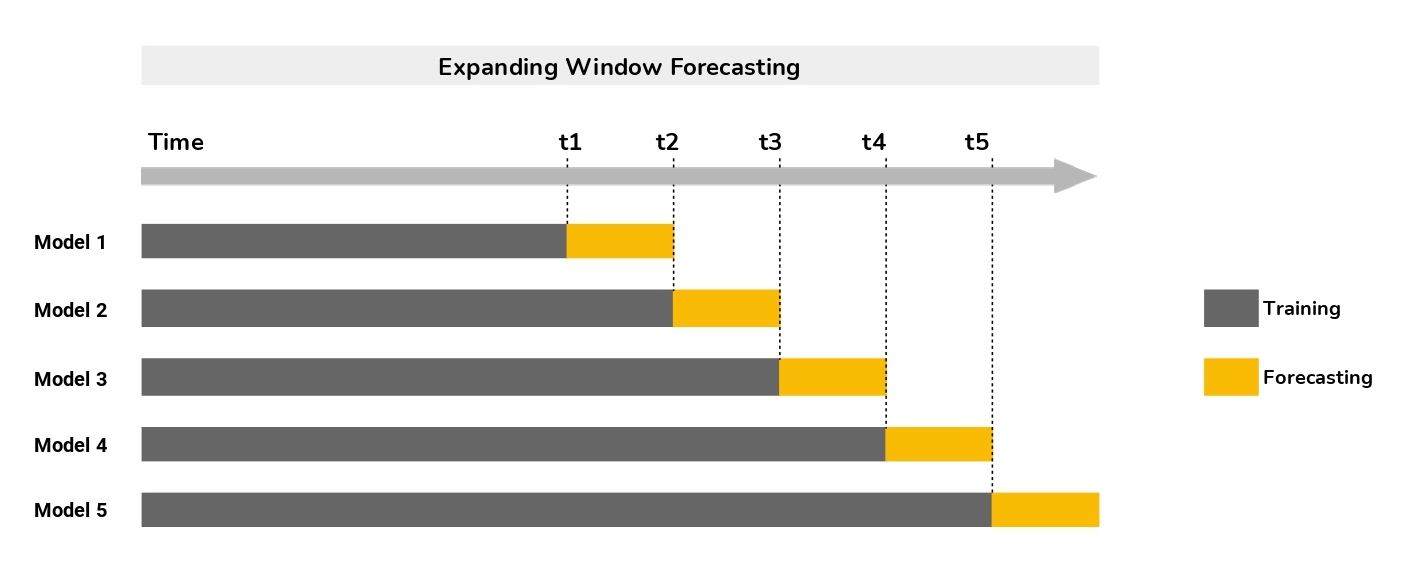

In [ ]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df['Change'][:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

In [ ]:
gm_1_preds

In [ ]:
gm_1_preds_scaled

In [ ]:
y_val_scaled

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

Next, I would inspect the estimated residuals from this first GARCH model.

In [ ]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

### 3.2. GARCH Model with Asymmetric Shocks Responses
#### GJR-GARCH : O=1추가
- https://www.e-kjfs.org/upload/pdf/kjfs-2009-38-2-137.pdf
- 조건부 분산이 과거 오차항의 방향성에 따른 비대칭적 효과도 잘 파악해낼 수 있도록 변동성 방정식을 모형화 함으로써, 비대칭 변동성반응을 포착해낼 수 있는 GJR-GARCH를 제시하였다.

## GJR-GARCH

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

Log-likelihood has increased quite a bit. Let's see how the conditional volatility looks.

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

In [ ]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df['Change'][:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

### 3.3. TARCH
#### 3.3.1. Bootstrap-based Forecasting for TARCH(1,1)
#### 3.3.2. Simulation-based Forecasting for TARCH(1,1)
There's another member in the GARCH family called **TARCH**, which is short for **Threshold Autoregressive Conditional Heteroskedasticity** (and also known as **ZARCH**). TARCH models the volatility using absolute values (instead of squares). This model is specified using `power=1.0` since the default power, `2.0`, corresponds to variance processes that evolve in squares. In addition, asymmetric impact is also incorporated into the GARCH framework by using a dummy variable

The volatility process in a TARCH(1,1) model is given by:

\begin{align*}
\sigma_{t} = \omega + \alpha|\epsilon_{t-1}| + \gamma|\epsilon_{t-1}|I_{[\epsilon_{t-1}<0]} + \beta\sigma_{t-1}
\end{align*}

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

In [ ]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

#### 3.3.1. Bootstrap-based Forecasting for TARCH(1,1)

(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html#TARCH)

TARCH models do not have closed-form (analytical) forecasts for horizons larger than 1, and so simulation or bootstrapping is required.

Bootstrap-based forecasts are nearly identical to simulation-based forecasts except that the values used to simulate the process are computed from historical data rather than using the assumed distribution of the residuals. Forecasts produced using this method also return an `ARCHModelForecastSimulation` containing information about the simulated paths.

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df['Change'][:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

TARCH one-step forecasting seems to produce some convergence issues. I still want to look at the results though.

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

The forecasted volatility does seem to catch up with the target better than all other models did. This is promising...

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled, 
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Bootstrap TARCH(1,1) has managed to achieve a lower Validation RMSPE than Naive Forecasting!!! Even RMSE is only a bit higher, but so far this has been the best model among all GARCH family members that I've found. 

(I'm not liking the ConvergenceWarning messages that TARCH produces during training though...)

#### 3.3.2. Simulation-based Forecasting for TARCH(1,1)

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df['Change'][:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING SIMULATION METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_sm_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_sm_preds)

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_sm_preds_scaled, 
          "Simulation TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_sm_preds_scaled, 
         "Simulation TARCH(1,1), Constant Mean, Skewt Dist")

Among the 2 forecasting methods, bootstrap seems to perform better on TARCH(1,1). It's probably because bootstrap uses historical data in to compute rather than using the assumed distribution of the residuals.

#### 3.3.3. Hyperparameter Tuning for TARCH

Next, I'll create a range of values for p, q and o from 0 to 3 (inclusive), and then record each's model's performance on unseen data using RMSE. Since `p` cannot take a value of `0`, I'll eliminate that from the list of permutations. 

In [ ]:
import itertools

In [ ]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# RMSE ON VALIDATION SET
rmse_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # SET SEED FOR REPRODUCIBILITY
    np.random.seed(seed)

    # FITTING TARCH(p,q,o) MODEL
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = df['Change'][:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # CONVERT PREDICTIONS
    y_preds = pd.Series(rolling_forecasts, index=val_idx)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmse_s.append(RMSE(y_val_scaled, y_preds_scaled))

In [ ]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSE
print(f'Lowest RMSE is {np.min(rmse_s)} using TARCH{pqo_s[np.argmin(rmse_s)]}')

In [ ]:
best_pqo = pqo_s[np.argmin(rmse_s)]

In [ ]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmse_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(rmse_s), ymax=np.max(rmse_s))
    ax3.set_ylabel('Validation RMSE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show();    


### 3.4. Final GARCH Model - TARCH(1,1,0)

I will train another sets of TARCH model using the p/q/o values found from tuning above.

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_120 = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
result_4 = t_120.fit(disp='off')
print(result_4.summary())

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_120, scaled_tarch_120_cond_vol = scale_tf_cond_vol(result_4)

In [ ]:
viz_cond_vol(scaled_tarch_120_cond_vol, f'TARCH{best_pqo[:2]}')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df['Change'][:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_120_preds_scaled, 
          f"Bootstrap TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")
plt.savefig(os.path.join(directory_to_img, 'best_tarch_preds.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_120_preds_scaled, 
         f"Bootstrap TARCH{best_pqo}, Constant Mean, Skewt Dist")